In [1]:
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras

# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential

from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Dense, Input, Lambda, LSTM

c:\Users\HP\anaconda3\envs\tf\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("../datasets/consolidated_data/gas_data.csv", index_col="DATEPRD")

date = df.index
df.head()

,BORE_GAS_VOL
DATEPRD,
2008-02-12,38888.67
2008-02-13,285246.16
2008-02-14,509954.88
2008-02-15,383426.67
2008-02-16,418474.00


In [3]:
#function to plot a series
def plot_series(x, y, type_=None, ylabel=None, format="-", start=None, end=None, label=None, multi_plot=True):
    if not multi_plot:
        plt.figure(figsize=(20, 10))
    plt.plot(x[start:end], y[start:end], format, label=label)
    plt.xlabel("Date", labelpad=50, fontsize=14)
    plt.ylabel(f"{ylabel} Volume", labelpad=50, fontsize=14)
    if label:
        plt.legend(fontsize=14)
    plt.grid(True, which='both')
    x_ticks = x.to_list()
    x_max = max(x_ticks)
    x_ticks = x_ticks[::round(len(x_ticks)/10)]
    x_ticks.append(x_max)
    plt.xticks(x_ticks, rotation = 30)
    if not multi_plot:
        plt.savefig(f'../plots/{ylabel.lower()}/{ylabel.lower()}_{type_}_time_series.png')
        plt.show()


#clear session 
def refresh():
    keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

class ResetStatesCallback(Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

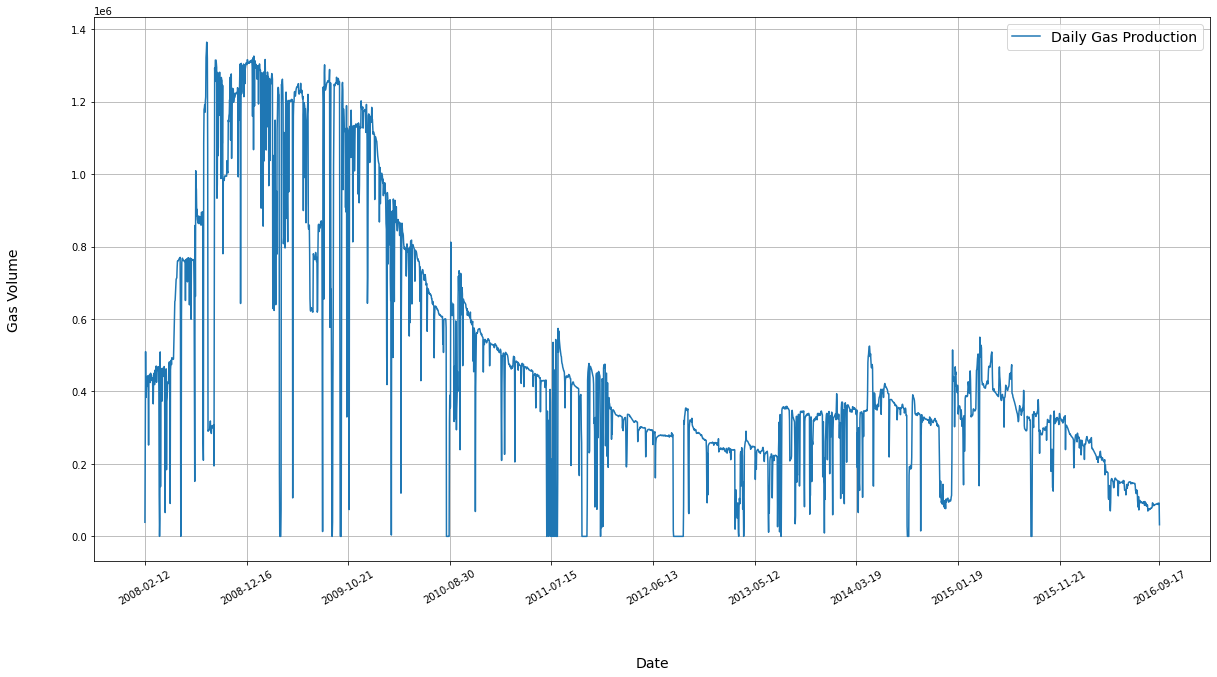

array([ 38888.67, 285246.16, 509954.88, ...,  91890.07,  91579.73,
        32165.98])

In [4]:
gas_data = df.BORE_GAS_VOL.to_numpy()
plot_series(date, gas_data, "unscaled", "Gas", label="Daily Gas Production", multi_plot=False)
gas_data

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

scaled_df = pd.DataFrame(scaled, index=df.index, columns=df.columns)
scaled_df.head()

,BORE_GAS_VOL
DATEPRD,
2008-02-12,0.028509
2008-02-13,0.209112
2008-02-14,0.373844
2008-02-15,0.281087
2008-02-16,0.306780


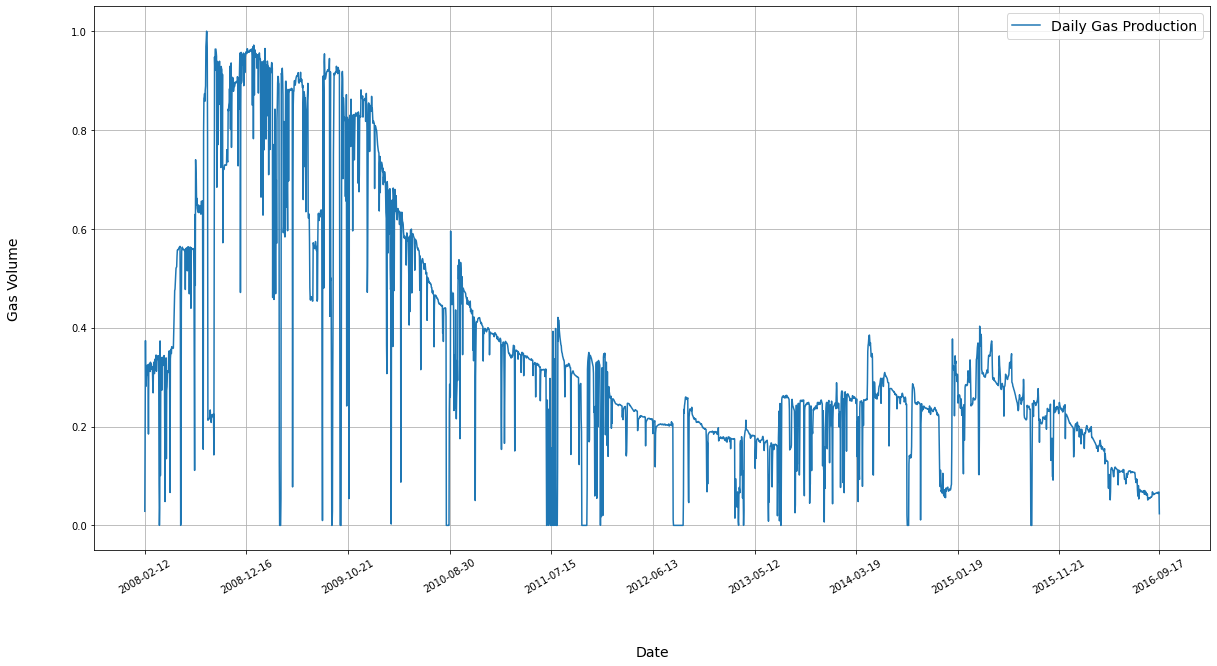

array([0.02850896, 0.20911156, 0.37384364, ..., 0.06736384, 0.06713633,
       0.02358061])

In [6]:
scaled_gas_data = scaled_df.BORE_GAS_VOL.to_numpy()
plot_series(date, scaled_gas_data, "scaled", "Gas", label="Daily Gas Production", multi_plot=False)

scaled_gas_data

In [7]:
#split the time series into training and validation sets
split_date = 2140

date_train = date[:split_date]
gas_train = scaled_gas_data[:split_date]

date_valid = date[split_date:]
gas_valid = scaled_gas_data[split_date:]

print(date_train.shape, gas_train.shape, date_valid.shape, gas_valid.shape)

(2140,) (2140,) (916,) (916,)


# NAIVE Forecast

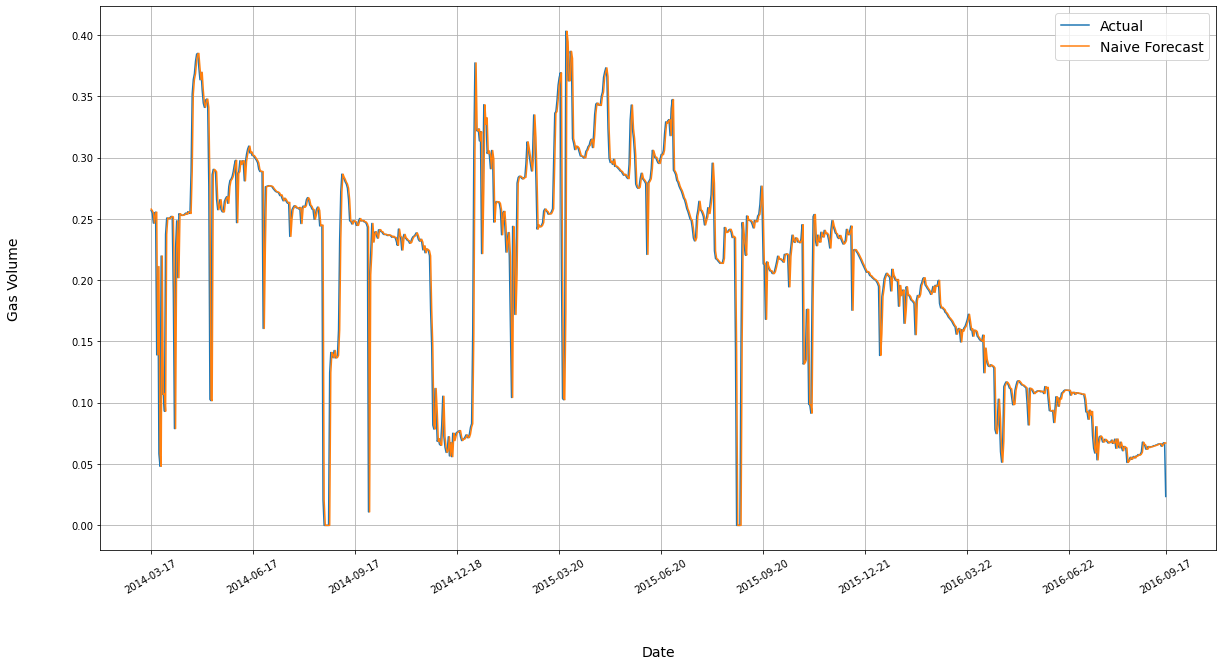

mae = 0.011332246330751548, 
mse = 0.0008716956372222275, 
rmse = 0.029524492158582973


In [23]:
naive_gas_forecast = scaled_gas_data[split_date - 1:-1]

plt.figure(figsize=(20, 10))

plot_series(date_valid, gas_valid, ylabel="Gas", label="Actual")
plot_series(date_valid, naive_gas_forecast, ylabel="Gas", label="Naive Forecast")

plt.savefig(f'../plots/gas/gas_naive_forecast.png')
plt.show()

mae = keras.metrics.mean_absolute_error(gas_valid, naive_gas_forecast).numpy()
mse = keras.metrics.mean_squared_error(gas_valid, naive_gas_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

# Moving Average

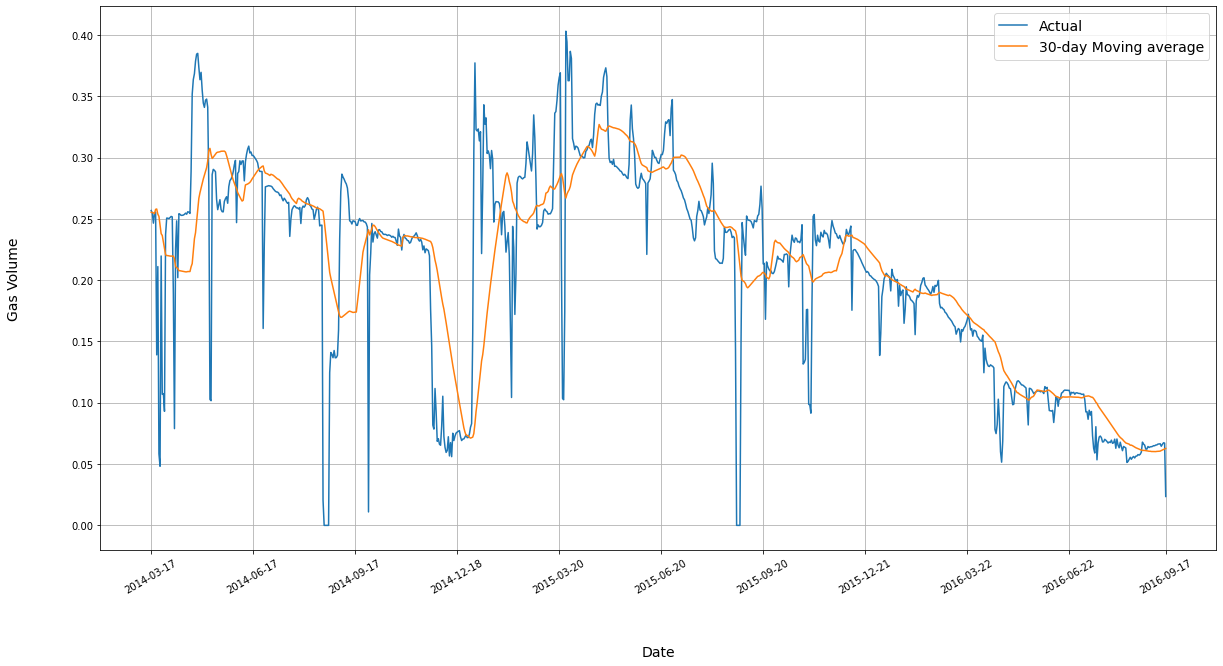

mae = 0.032397228580513214, 
mse = 0.0029799831644729074, 
rmse = 0.0545892220541098


In [24]:
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
    If window_size=1, then this is equivalent to naive forecast"""
    
    mov = np.cumsum(series)
    mov[window_size:] = mov[window_size:] - mov[:-window_size]
    
    return mov[window_size - 1:-1] / window_size
    
gas_moving_avg = moving_average_forecast(scaled_gas_data, 30)[split_date - 30:]

plt.figure(figsize=(20, 10))

plot_series(date_valid, gas_valid, ylabel="Gas", label="Actual")
plot_series(date_valid, gas_moving_avg, ylabel="Gas", label="30-day Moving average")

plt.savefig(f'../plots/gas/gas_30d_mov_avg_forecast.png')
plt.show()

mae = keras.metrics.mean_absolute_error(gas_valid, gas_moving_avg).numpy()
mse = keras.metrics.mean_squared_error(gas_valid, gas_moving_avg).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

# Linear Model

In [19]:
def window_dataset(series, window_size, batch_size=30, shuffle_buffer=100):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(2)
    
    return dataset


def model_forecast(model, series, window_size):
    
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(30).prefetch(2)
    
    forecast = model.predict(dataset)
    
    return forecast

In [ ]:
refresh()

window_size = 30

gas_train_set = window_dataset(gas_train, window_size)

model = Sequential( [ Dense(1, input_shape=[window_size]) ] )

lr_schedule = LearningRateScheduler(
                lambda epoch: 1e-4 * 10**(epoch / 30)
                )

optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(gas_train_set, epochs=100, callbacks=[lr_schedule])

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([5e-5, 5e-1, 0, 0.3])

plt.show()

max(history.history["loss"])

In [25]:
keras.backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

gas_train_set = window_dataset(gas_train, window_size)
gas_valid_set = window_dataset(gas_valid, window_size)

model = Sequential( [ Dense(1, input_shape=[window_size]) ] )

optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = EarlyStopping(patience=10)

model.fit(
    
    gas_train_set,
    epochs=500,
    validation_data=gas_valid_set,
    callbacks=[early_stopping]

)

model.save('linear_gas_model.h5')

Epoch 1/500
71/71 [==============================] - 8s 40ms/step - loss: 0.1593 - mae: 0.3992 - val_loss: 0.0064 - val_mae: 0.0925
Epoch 2/500
71/71 [==============================] - 1s 14ms/step - loss: 0.0275 - mae: 0.1402 - val_loss: 0.0035 - val_mae: 0.0561
Epoch 3/500
71/71 [==============================] - 1s 15ms/step - loss: 0.0267 - mae: 0.1416 - val_loss: 0.0034 - val_mae: 0.0552
Epoch 4/500
71/71 [==============================] - 1s 17ms/step - loss: 0.0254 - mae: 0.1370 - val_loss: 0.0032 - val_mae: 0.0525
Epoch 5/500
71/71 [==============================] - 1s 13ms/step - loss: 0.0243 - mae: 0.1341 - val_loss: 0.0031 - val_mae: 0.0515
Epoch 6/500
71/71 [==============================] - 1s 13ms/step - loss: 0.0233 - mae: 0.1303 - val_loss: 0.0029 - val_mae: 0.0497
Epoch 7/500
71/71 [==============================] - 1s 13ms/step - loss: 0.0224 - mae: 0.1273 - val_loss: 0.0028 - val_mae: 0.0482
Epoch 8/500
71/71 [==============================] - 1s 13ms/step - loss: 0.

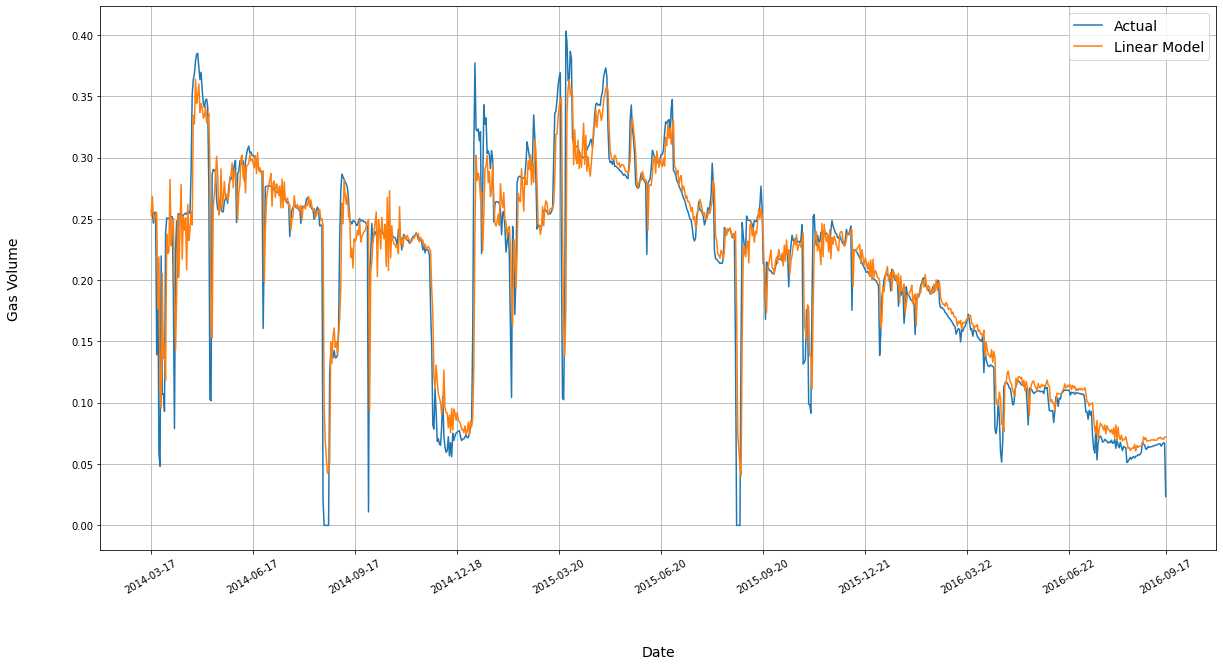

mae = 0.016262970864772797, 
mse = 0.0009474352700635791, 
rmse = 0.030780436482668323
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 31        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'dense/kernel:0' shape=(30, 1) dtype=float32, numpy=
array([[ 0.00915948],
       [ 0.03930292],
       [-0.09717624],
       [ 0.03843413],
       [ 0.01170989],
       [ 0.03488468],
       [ 0.01859706],
       [ 0.04115361],
       [ 0.0027131 ],
       [-0.0241794 ],
       [ 0.09344763],
       [-0.15943672],
       [ 0.14151964],
       [-0.1385156 ],
       [ 0.12101036],
       [-0.04157323],
       [ 0.03091143],
       [ 0.01007875],
       [-0.06715616],
       [ 0.08570512],
       [-0.00472662],
       [-0.07842366],
       [ 0.16493

In [26]:
linear_gas_forecast = model_forecast(model, scaled_gas_data[split_date - window_size:-1], window_size)[:, 0]

plt.figure(figsize=(20, 10))

plot_series(date_valid, gas_valid, ylabel="Gas", label="Actual")
plot_series(date_valid, linear_gas_forecast, ylabel="Gas", label="Linear Model")

plt.savefig(f'../plots/gas/gas_linear_forecast.png')
plt.show()

mae = keras.metrics.mean_absolute_error(gas_valid, linear_gas_forecast).numpy()
mse = keras.metrics.mean_squared_error(gas_valid, linear_gas_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

model.summary()
print(model.trainable_variables)

#  FF-NN

In [ ]:
refresh()

window_size = 30

gas_train_set = window_dataset(gas_train, window_size)

model = Sequential([
            Dense(10, activation="relu", input_shape=[window_size]),
            Dense(10, activation="relu"),
            Dense(1)
        ])

lr_schedule = LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(gas_train_set, epochs=100, callbacks=[lr_schedule])

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1, 0, 0.12])

plt.show()

max(history.history["lr"])

In [27]:
refresh()

window_size = 30

gas_train_set = window_dataset(gas_train, window_size)
gas_valid_set = window_dataset(gas_valid, window_size)

model = Sequential([
            Dense(10, activation="relu", input_shape=[window_size]),
            Dense(10, activation="relu"),
            Dense(1)
        ])

optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = EarlyStopping(patience=10)

model.fit(gas_train_set,
          epochs=500,
          validation_data=gas_valid_set,
          callbacks=[early_stopping])

model.save('ffnn_gas_model.h5')

Epoch 1/500
71/71 [==============================] - 44s 31ms/step - loss: 0.0399 - mae: 0.2001 - val_loss: 0.0031 - val_mae: 0.0639
Epoch 2/500
71/71 [==============================] - 4s 52ms/step - loss: 0.0113 - mae: 0.0969 - val_loss: 0.0019 - val_mae: 0.0434
Epoch 3/500
71/71 [==============================] - 1s 14ms/step - loss: 0.0115 - mae: 0.0998 - val_loss: 0.0019 - val_mae: 0.0428
Epoch 4/500
71/71 [==============================] - 1s 16ms/step - loss: 0.0110 - mae: 0.0956 - val_loss: 0.0018 - val_mae: 0.0405
Epoch 5/500
71/71 [==============================] - 1s 20ms/step - loss: 0.0107 - mae: 0.0937 - val_loss: 0.0017 - val_mae: 0.0392
Epoch 6/500
71/71 [==============================] - 2s 20ms/step - loss: 0.0103 - mae: 0.0912 - val_loss: 0.0016 - val_mae: 0.0378
Epoch 7/500
71/71 [==============================] - 1s 17ms/step - loss: 0.0101 - mae: 0.0893 - val_loss: 0.0015 - val_mae: 0.0364
Epoch 8/500
71/71 [==============================] - 1s 15ms/step - loss: 0

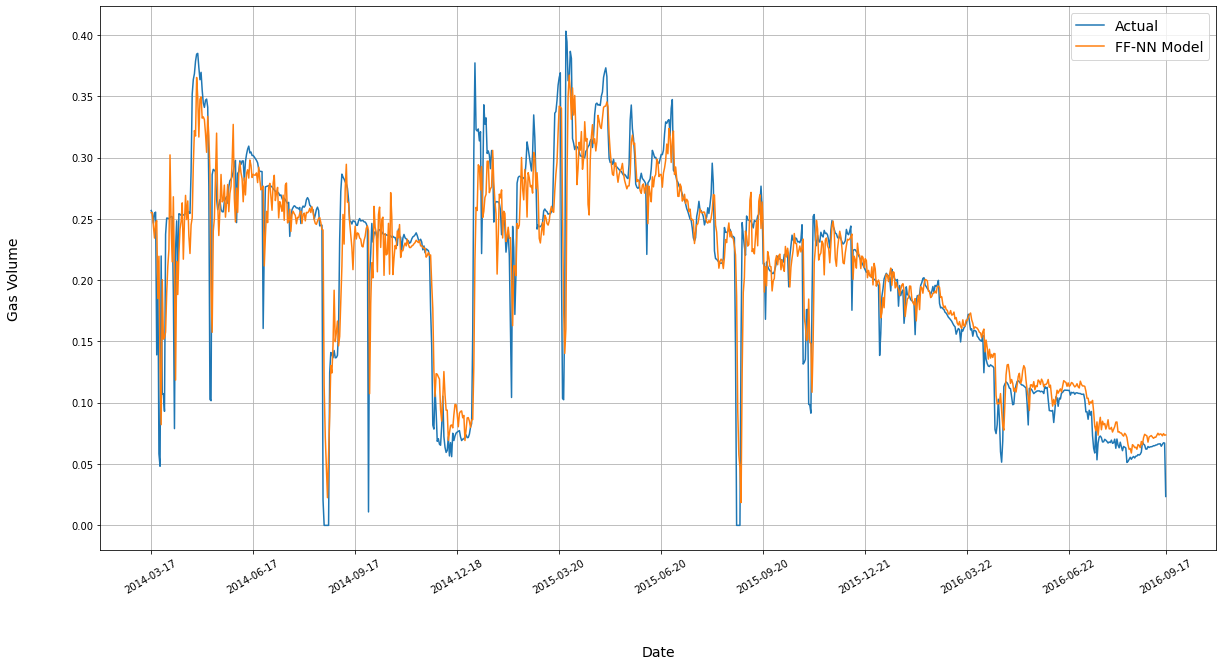

mae = 0.019211512058973312, 
mse = 0.0011159389978274703, 
rmse = 0.033405673138367835
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                310       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'dense/kernel:0' shape=(30, 10) dtype=float32, numpy=
array([[ 0.20406866,  0.11649283, -0.3765996 , -0.12793078, -0.01066834,
        -0.05361056, -0.32081467, -0.37077764, -0.15673453, -0.01955002],
       [ 0.13462754, -0.3090755 ,  0.33171946, -0.24820738,  0.13362546,
         0.04

In [29]:
ffnn_gas_forecast = model_forecast(
    
                    model,
                    scaled_gas_data[split_date - window_size:-1],
                    window_size

                                )[:, 0]

plt.figure(figsize=(20, 10))

plot_series(date_valid, gas_valid, ylabel="Gas", label="Actual")
plot_series(date_valid, ffnn_gas_forecast, ylabel="Gas", label="FF-NN Model")

plt.savefig(f'../plots/gas/gas_ffnn_forecast.png')
plt.show()

mae = keras.metrics.mean_absolute_error(gas_valid, ffnn_gas_forecast).numpy()
mse = keras.metrics.mean_squared_error(gas_valid, ffnn_gas_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

model.summary()
print(model.trainable_variables)

# RNN Model - LSTM

In [8]:
def sequential_window_dataset(series, window_size):
    
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=window_size, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[1:]))
    
    return dataset.batch(1).prefetch(1)

In [ ]:
refresh()

window_size = 30

gas_train_set = sequential_window_dataset(gas_train, window_size)

model = Sequential([
    
        LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(100, return_sequences=True, stateful=True),
        Dense(1)
    
        ])

learning_rate_schedule = LearningRateScheduler(lambda epoch: 1e-5 * 10**(epoch / 20))
reset_states = ResetStatesCallback()

optimizer = keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)

model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

history = model.fit(gas_train_set, epochs=100, callbacks=[learning_rate_schedule, reset_states])

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 10, 0.009, 0.12])
plt.show()

max(history.history["lr"])

In [9]:
refresh()

window_size = 30
gas_train_set = sequential_window_dataset(gas_train, window_size)
gas_valid_set = sequential_window_dataset(gas_valid, window_size)

model = Sequential([
                    
        LSTM(100, return_sequences=True, stateful=True, batch_input_shape=[1, None, 1]),
        LSTM(100, return_sequences=True, stateful=True),
        Dense(1)
        
        ])

optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

reset_states = ResetStatesCallback()
model_checkpoint = ModelCheckpoint("lstm/LSTM_gas_checkpoint.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=50)

history = model.fit(gas_train_set, epochs=500, validation_data=gas_valid_set, 
          callbacks=[early_stopping, model_checkpoint, reset_states])

model.save('lstm/lstm_gas_model.h5')

Epoch 1/500
71/71 [==============================] - 16s 79ms/step - loss: 0.0815 - mae: 0.3177 - val_loss: 0.0071 - val_mae: 0.0974
Epoch 2/500
71/71 [==============================] - 3s 35ms/step - loss: 0.0345 - mae: 0.2175 - val_loss: 0.0054 - val_mae: 0.0825
Epoch 3/500
71/71 [==============================] - 2s 30ms/step - loss: 0.0298 - mae: 0.2001 - val_loss: 0.0044 - val_mae: 0.0738
Epoch 4/500
71/71 [==============================] - 2s 30ms/step - loss: 0.0254 - mae: 0.1826 - val_loss: 0.0035 - val_mae: 0.0651
Epoch 5/500
71/71 [==============================] - 2s 32ms/step - loss: 0.0216 - mae: 0.1661 - val_loss: 0.0028 - val_mae: 0.0571
Epoch 6/500
71/71 [==============================] - 2s 33ms/step - loss: 0.0183 - mae: 0.1505 - val_loss: 0.0022 - val_mae: 0.0500
Epoch 7/500
71/71 [==============================] - 2s 32ms/step - loss: 0.0156 - mae: 0.1360 - val_loss: 0.0018 - val_mae: 0.0440
Epoch 8/500
71/71 [==============================] - 2s 31ms/step - loss: 0

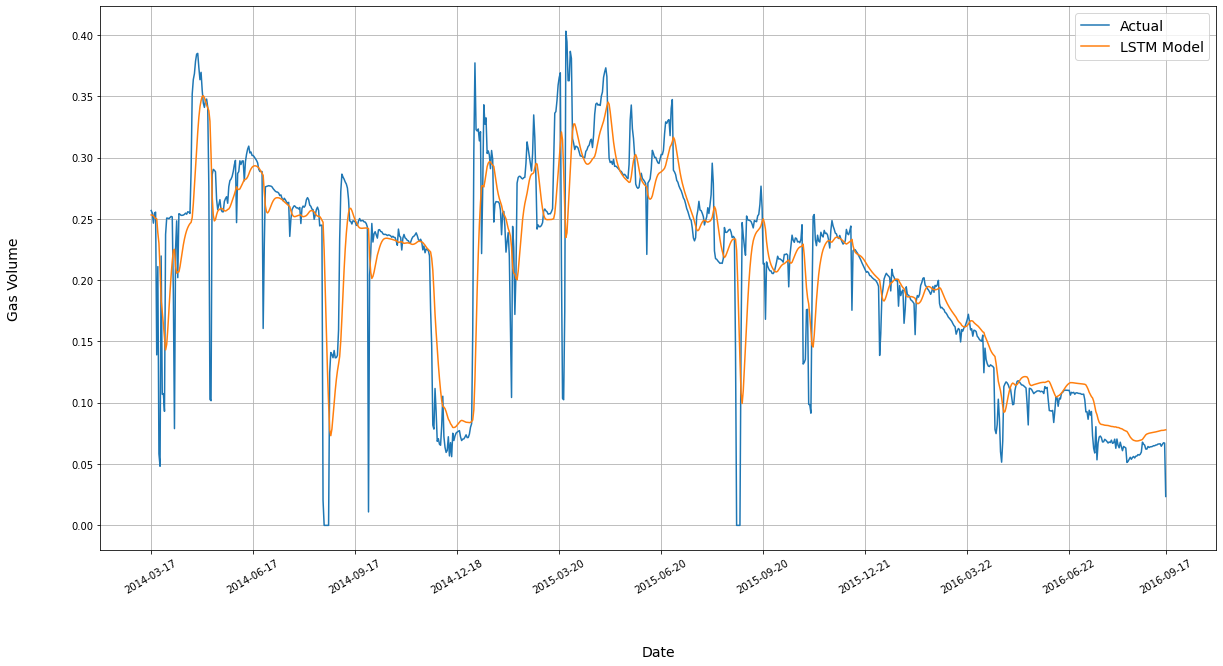

mae = 0.023276330903172493, 
mse = 0.0017854965990409255, 
rmse = 0.042255136954468926
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, None, 100)            40800     
_________________________________________________________________
lstm_1 (LSTM)                (1, None, 100)            80400     
_________________________________________________________________
dense (Dense)                (1, None, 1)              101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'lstm/lstm_cell/kernel:0' shape=(1, 400) dtype=float32, numpy=
array([[ 3.97784114e-02, -1.41512379e-02, -3.52972522e-02,
        -8.05603713e-03, -1.13467135e-01,  4.81447838e-02,
         5.83619289e-02,  9.18634087e-02, -6.74388781e-02,
        -6.00730851e-02, -4.02533896e-0

In [10]:
#forecast
LSTM_gas_forecast = model.predict(scaled_gas_data[np.newaxis, :, np.newaxis])
LSTM_gas_forecast = LSTM_gas_forecast[0, split_date - 1:-1, 0]

plt.figure(figsize=(20, 10))

plot_series(date_valid, gas_valid, ylabel="Gas", label="Actual")
plot_series(date_valid, LSTM_gas_forecast, ylabel="Gas", label="LSTM Model")

plt.savefig(f'../plots/gas/gas_lstm_forecast.png')
plt.show()

mae = keras.metrics.mean_absolute_error(gas_valid, LSTM_gas_forecast).numpy()
mse = keras.metrics.mean_squared_error(gas_valid, LSTM_gas_forecast).numpy()
rmse = math.sqrt(mse)

print(f'mae = {mae}, \nmse = {mse}, \nrmse = {rmse}')

model.summary()
print(model.trainable_variables)